  0%|          | 0/5 [00:00<?, ?it/s]

the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (144, 512, 512)


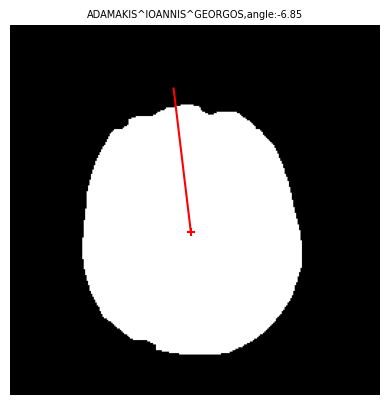

the initial angle is:  -6.852316845195276
patient's name:ADAMAKIS^IOANNIS^GEORGOS,patient's sex:M,patients'age:38,Glasgow Coma Scale:15,Class:0
----------------------------------------------------------------------------------------------------
0.0 1.0


 20%|██        | 1/5 [00:33<02:14, 33.71s/it]

the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (152, 512, 512)


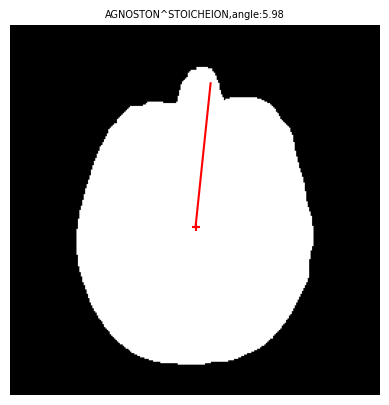

the initial angle is:  5.984342406051013
patient's name:AGNOSTON^STOICHEION,patient's sex:NA,patients'age:NA,Glasgow Coma Scale:15,Class:0
----------------------------------------------------------------------------------------------------
0.0 1.0


 40%|████      | 2/5 [01:05<01:37, 32.54s/it]

the type of scan is: Brain 1.25 mm
The actual shape of the scan is: (128, 512, 512)


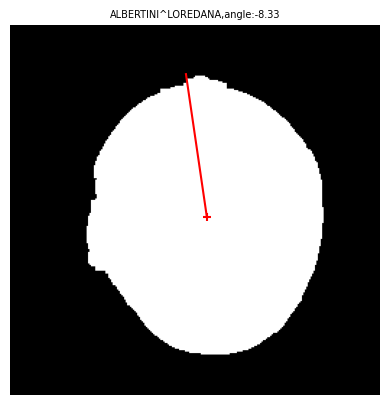

the initial angle is:  -8.329856001450878
patient's name:ALBERTINI^LOREDANA,patient's sex:F,patients'age:42,Glasgow Coma Scale:NA,Class:1
----------------------------------------------------------------------------------------------------
0.0 1.0


 60%|██████    | 3/5 [01:33<01:01, 30.62s/it]

the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (136, 512, 512)


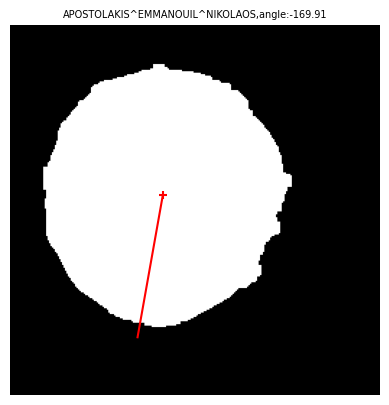

the initial angle is:  -169.9117060355945
procceding rotation... <-14 degrees
angle in perpenticular plane: -169.9117060355945
patient's name:APOSTOLAKIS^EMMANOUIL^NIKOLAOS,patient's sex:M,patients'age:77,Glasgow Coma Scale:1,Class:0


 80%|████████  | 4/5 [02:03<00:30, 30.30s/it]

0.0 1.0
the type of scan is: RoutineSeq  1.5  H30s
The actual shape of the scan is: (108, 512, 512)


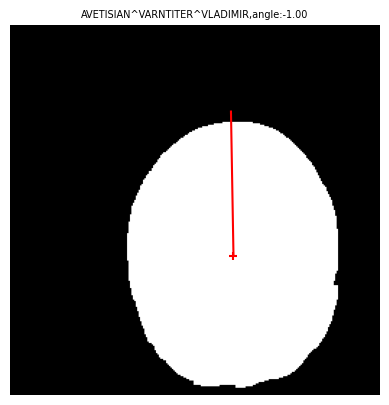

the initial angle is:  -1.0021564835347476
patient's name:AVETISIAN^VARNTITER^VLADIMIR,patient's sex:F,patients'age:20,Glasgow Coma Scale:15,Class:1
----------------------------------------------------------------------------------------------------
0.0 1.0


100%|██████████| 5/5 [02:27<00:00, 29.41s/it]


(5,)

In [1]:
import pydicom as dcm
import os
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from segment_brain import segment
from tqdm import tqdm
import re
from CT_DATASET_module_with_Classes_rescale import *


PATH_WITH_ALL_SCANS = r'C:\Users\user1\Desktop\WIDE_RANGE' 
PATH_WITH_ALL_SCANS = r'C:\Users\user1\Desktop\NORMAL' 
PATH_WITH_ALL_SCANS = r'C:\Users\user1\Desktop\TEST' 
desired_volume_dims_after_resampling = (120,256,256)
THRESHOLD = 20
all_patients =CT_DATASET(PATH_WITH_ALL_SCANS,desired_volume_dims_after_resampling)

patients = []
for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)[:10]):  
# for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)):    
        # for folder in os.listdir(os.path.join(PATH_WITH_ALL_SCANS,patient)):
            patients.append(all_patients.process_scan(os.path.join(PATH_WITH_ALL_SCANS,patient),patient))

patients = np.array(patients)
patients.shape

In [2]:
np.save("patients",patients)

In [1]:

import pydicom as dcm
import os
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from segment_brain import segment
from tqdm import tqdm
import re
# from CT_DATASET_module_with_Classes_rescale import *

patients = np.load("patients.npy",allow_pickle=True)
desired_volume_dims_after_resampling = (120,256,256)

In [2]:
X = np.array([patients[i]['volume']  for i in range(len(patients)) ])
X =np.transpose(X,(0,2,3,1))
print(X.shape)


(5, 256, 256, 120)


Segment the brain

In [3]:
from segment_brain import segment_all_patients_slices

X_segmented = segment_all_patients_slices(X)
X_segmented.shape

(5, 256, 256, 120)

(<Axes: >, <matplotlib.image.AxesImage at 0x25ea4a2d390>)

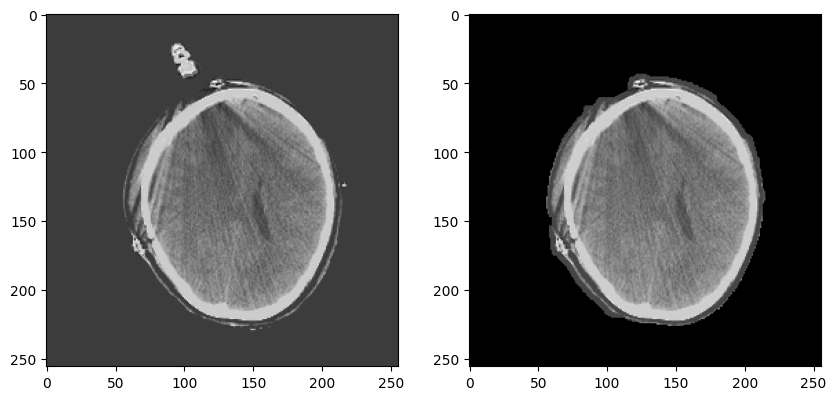

In [12]:
SLICE=np.random.randint(0,120)
PATIENT = np.random.randint(0,X.shape[0])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1),plt.imshow(X[PATIENT,:,:,SLICE],cmap='gray')
plt.subplot(1,2,2),plt.imshow(X_segmented[PATIENT,:,:,SLICE],cmap='gray')


0.30000000000000004


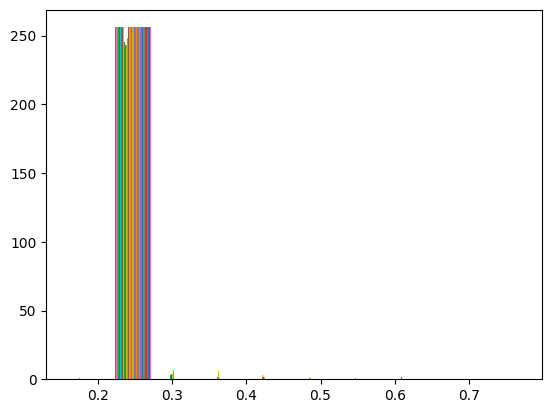

In [5]:
def find_threshold(volume):
    counts, bins = np.histogram(volume, bins=10)
    bin_max_index =np.argmax(counts)
    # volume[volume<=bins[bin_max_index+1]]=0
    return bins[bin_max_index+1]

print(find_threshold(X))
plt.hist(X[0,36])
thresholded = X>find_threshold(X)
# thresholded = X>0.2
mask = np.vectorize(segment, signature='(n,m)->(n,m)')(thresholded)
X = X*mask
# X[X<=0]=0 ############# εγω τυο βαζω αυτό για να ειναι η απόλυτη μάσκα

In [4]:
y = np.array (  [patients[i]['Class']  for i in range(len(patients)) ]).astype('int32')

In [5]:
# SLICE=np.random.randint(0,120)
# plt.imshow(mask[1][:,:,SLICE],cmap='gray')
# # X[2][:,:,SLICE][50,50]

In [6]:
from sklearn.preprocessing import LabelEncoder

labels_sex = np.array([patients[i]['sex']  for i in range(len(patients)) ])
le = LabelEncoder()
le.fit(labels_sex)
labels_sex_transf = le.transform(labels_sex)
labels_sex_transf, labels_sex

(array([1, 2, 0, 1, 0]), array(['M', 'NA', 'F', 'M', 'F'], dtype='<U2'))

In [7]:
from sklearn.preprocessing import LabelEncoder

labels_age = np.array([patients[i]['age']  for i in range(len(patients)) ])
labels_age_categ = []
for age in labels_age:
    if age=='NA':
        labels_age_categ.append('NA')
    elif int(age)<30:
        labels_age_categ.append('Adult')
    elif int(age)>=30 and int(age)<60:
        labels_age_categ.append('Middle')
    else:
        labels_age_categ.append('Old')

labels_age_categ =np.array(labels_age_categ)

le = LabelEncoder()
le.fit(labels_age_categ)
labels_age_transf = le.transform(labels_age_categ)
labels_age_transf,labels_age_categ


(array([1, 2, 1, 3, 0]),
 array(['Middle', 'NA', 'Middle', 'Old', 'Adult'], dtype='<U6'))

In [8]:
labels_GCS = np.array([patients[i]['Glasgow Coma Scale']  for i in range(len(patients)) ])
labels_GCS_categ = []
for GCS in labels_GCS:
    if GCS=='NA':
        labels_GCS_categ.append('NA')
    elif int(GCS)<=8:
        labels_GCS_categ.append('HIGH')
    else:
        labels_GCS_categ.append('LOW')

labels_GCS_categ =np.array(labels_GCS_categ)

le = LabelEncoder()
le.fit(labels_GCS_categ)
labels_GCS_transf = le.transform(labels_GCS_categ)
labels_GCS_transf,labels_GCS_categ

(array([1, 1, 2, 0, 1]),
 array(['LOW', 'LOW', 'NA', 'HIGH', 'LOW'], dtype='<U4'))

In [9]:
from sklearn.model_selection import train_test_split
X_train,  X_test,  y_train, y_test,   labels_sex_train, labels_sex_test,  labels_age_train, labels_age_test ,label_GCS_train, label_GCS_test= train_test_split( X, y,
                                                                                                                                                                labels_sex_transf,
                                                                                                                                                                labels_age_transf,
                                                                                                                                                                labels_GCS_transf,
                                                                                                                                                                test_size=0.2)

In [10]:
from My_model import MultipleInputsModel

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate,Reshape,Embedding, Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout



model =MultipleInputsModel(input_shape=(256,256,120),sex_label_shape=(1,),age_label_shape=(1,),GCS_label_shape=(1,),
                           age_num_classes=len(np.unique(labels_age_transf)),
                           sex_num_classes=len(np.unique(labels_sex_transf)),
                           GCS_num_classes=len(np.unique(labels_GCS_transf)),
                           )
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)


In [11]:
import tensorflow as tf
import numpy as np
from scipy import ndimage
import random


from augmentations import CT_augmentations
def train_preprocessing(volume, labels_sex,labels_age,labels_gcs,y):
# def train_preprocessing(volume,y):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = CT_augmentations(volume)
    
    # volume = tf.expand_dims(volume, axis=3)
    print(volume.dtype)
    return (volume, labels_sex,labels_age,labels_gcs),y
    # return volume,y

def test_preprocessing(volume, labels_sex,labels_age,labels_gcs,y):
# def test_preprocessing(volume,y):

    # volume = tf.expand_dims(volume, axis=3)
    return (volume, labels_sex,labels_age,labels_gcs),y
    # return volume,y

scipy_rotate
0.25097022315947903 tf.Tensor(0.25097022315947914, shape=(), dtype=float64) ALBERTINI^LOREDANA 99


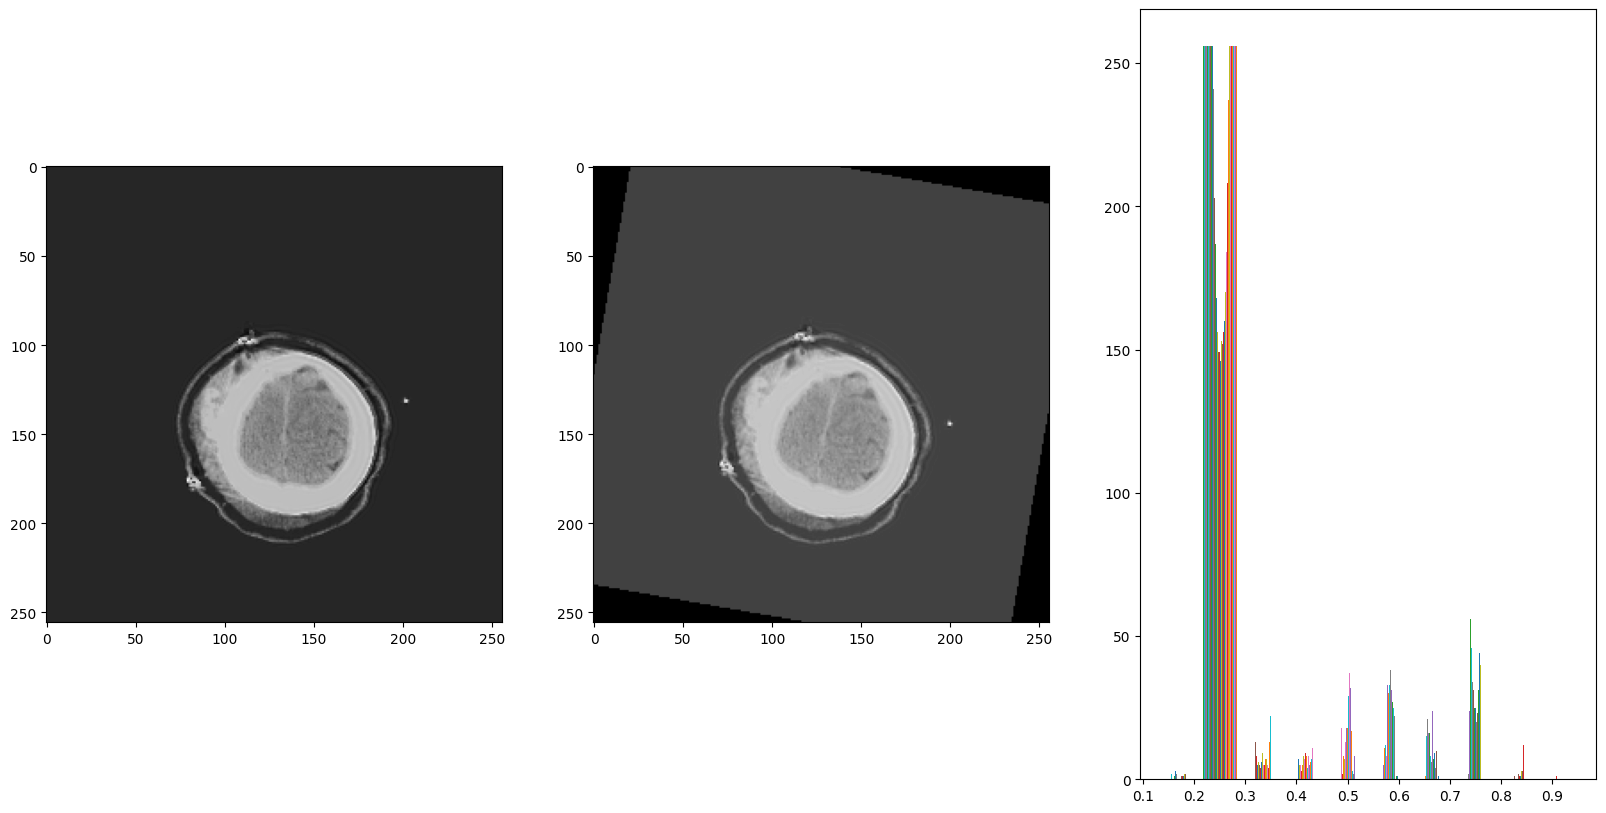

In [7]:
from augmentations import CT_augmentations
SLICE = np.random.randint(0,102)
PATIENT = np.random.randint(0,X.shape[0])
plt.figure(figsize=(20,10))
test_or =  X[PATIENT][:,:,SLICE]
test_art = CT_augmentations(X[PATIENT])[:,:,SLICE]
print(test_or[50,50],test_art[50,50], patients[PATIENT]['name'],SLICE)

plt.subplot(1,3,1),plt.imshow(test_or,cmap='gray')
plt.subplot(1,3,2),plt.imshow(test_art,cmap='gray')
plt.subplot(1,3,3),plt.hist(test_or)
plt.show()


In [21]:
import tensorflow as tf 

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train,    
                                                     labels_sex_train, 
                                                     labels_age_train, 
                                                     label_GCS_train, 
                                                     y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test,    
                                                     labels_sex_test, 
                                                     labels_age_test, 
                                                     label_GCS_test, 
                                                     y_test))



# for volume,sex,age,gcs,label in train_loader:
#     print(volume.shape)

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)




<dtype: 'float64'>


In [22]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
scipy_rotate
blur
scipy_rotate

blur
2/2 - 7s - loss: 7.9861 - accuracy: 0.5000 - val_loss: 1.2815 - val_accuracy: 0.0000e+00 - 7s/epoch - 3s/step
Epoch 2/10
scipy_rotate
2/2 - 3s - loss: 1.1839 - accuracy: 0.5000 - val_loss: 0.7557 - val_accuracy: 0.0000e+00 - 3s/epoch - 2s/step
Epoch 3/10
scipy_rotate
blur
2/2 - 4s - loss: 0.6900 - accuracy: 0.5000 - val_loss: 0.7051 - val_accuracy: 0.0000e+00 - 4s/epoch - 2s/step
Epoch 4/10
scipy_rotate
blur
scipy_rotate
2/2 - 5s - loss: 0.7953 - accuracy: 0.0000e+00 - val_loss: 0.6163 - val_accuracy: 1.0000 - 5s/epoch - 3s/step
Epoch 5/10
blur
scipy_rotate
2/2 - 4s - loss: 0.6141 - accuracy: 1.0000 - val_loss: 0.6145 - val_accuracy: 1.0000 - 4s/epoch - 2s/step
Epoch 6/10
blur
2/2 - 3s - loss: 0.6610 - accuracy: 0.5000 - val_loss: 0.5572 - val_accuracy: 1.0000 - 3s/epoch - 1s/step
Epoch 7/10
scipy_rotate
blur
scipy_rotate
blur
2/2 - 6s - loss: 1.0424 - accuracy: 0.5000 - val_loss: 0.4498 - val_accuracy: 1.0000 - 6s/epoch - 3s/step
Epoch 8

https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras

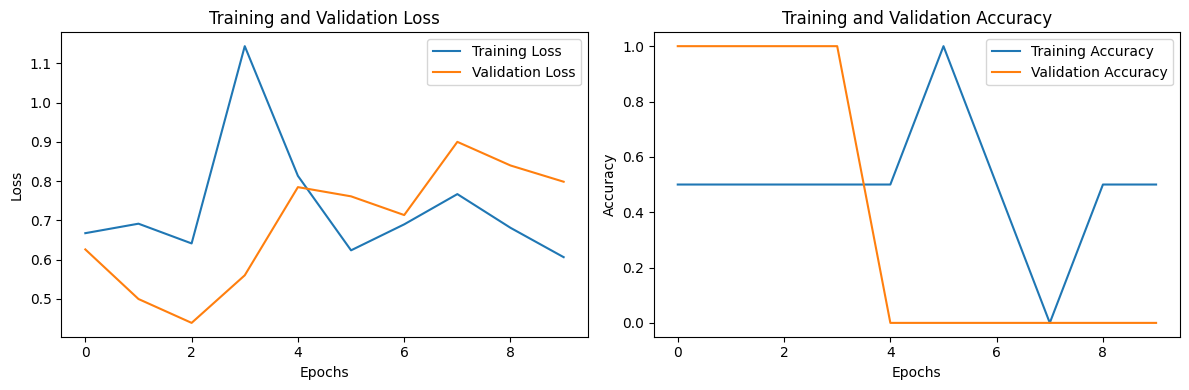

In [20]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:


import plotly.graph_objects as go
import plotly.express as px



# Create a Plotly figure for loss
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['loss'],
                             mode='lines',
                             name='Training Loss',
                             line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='orange')))

fig_loss.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epochs',
                      yaxis_title='Loss',
                      template='plotly_dark')

# Create a Plotly figure for accuracy
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['accuracy'],
                                 mode='lines',
                                 name='Training Accuracy',
                                 line=dict(color='green')))
fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['val_accuracy'],
                                 mode='lines',
                                 name='Validation Accuracy',
                                 line=dict(color='red')))

fig_accuracy.update_layout(title='Training and Validation Accuracy',
                          xaxis_title='Epochs',
                          yaxis_title='Accuracy',
                          template='plotly_dark')

# Show the figures
fig_loss.show()
fig_accuracy.show()



In [22]:
model.predict([X_test,labels_sex_test,labels_age_test,label_GCS_test] )

1/1 [==============================] - 0s 136ms/step


array([[0.44999346]], dtype=float32)

In [23]:
model.predict([np.expand_dims(X_test[0],axis=0) ,   np.array([labels_sex_test[0]]),  np.array([labels_sex_test[0]]) ,np.array([label_GCS_test[0]])  ] )

1/1 [==============================] - 0s 136ms/step


array([[0.44999346]], dtype=float32)

In [ ]:
#δεν παιζει τα labels

import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming you have a single image file path, sex label, and age label
image_path = 'PATH_TO_IMAGE'
sex_label = 'Male'  # or 'Female'
age_label = 'Middle'  # or any appropriate age label

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Assuming you normalized your images during training

# Encode sex label
sex_encoded = le.transform([sex_label])

# Encode age label
age_encoded = np.array([age_label])

# Make the prediction
prediction = model.predict([np.expand_dims(X_test[0],axis=0), sex_encoded, age_encoded])

# Convert the prediction to a binary class (0 or 1)
binary_prediction = 1 if prediction > 0.5 else 0

print("Predicted Probability:", prediction)
print("Predicted Class:", binary_prediction)

Artifact augmentations

4.693433798199474e-53


(0.0, 1.0)

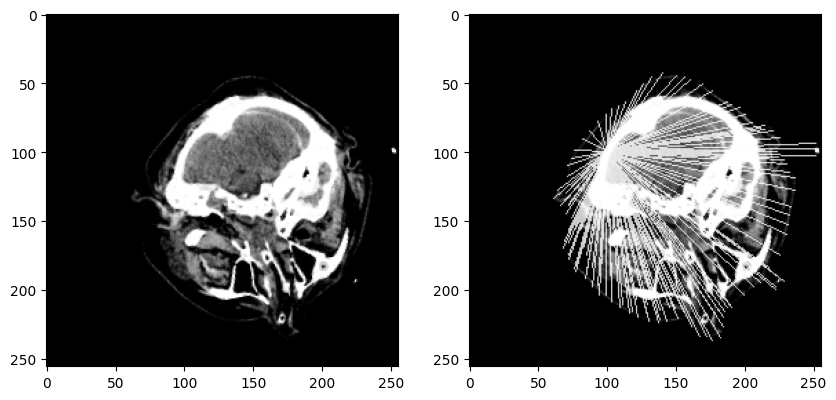

In [70]:

def create_probe_artifact(volume):
    def for_one_slice(image):
        img_copy = image.copy()
        THRESHOLD = 0.1
        thresh = img_copy*255>THRESHOLD
        # Find contours of bright regions
        contours, _ = cv2.findContours(thresh.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Draw star-like pattern on the image
        for contour in contours:
            # Calculate the centroid of each contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"]*2 / M["m00"]*0.02) #int(M["m10"] / M["m00"])
                cY = int(M["m01"]*1.6 / M["m00"]*0.2)
            else:
                cX, cY = 50, 50
            # Draw lines from centroid to contour points
            for point in contour[::7]:
                x, y = point[0]
                cv2.line(img_copy, (100, 100), (x, y), (255, 255, 255), 1)

            img_copy[img_copy<=0]=0 
            img_copy[img_copy>=img_copy.max()]=1
            img_copy[img_copy>=1]=1 

            image[image<=0]=0 
            image[image>=image.max()]=1
            image[image>=1]=1 


        return img_copy*0.8+image*0.2
    
    
    volume_with_artifact= []
    for slice in range(volume.shape[-1]):
        volume_with_artifact.append(for_one_slice(volume[:,:,slice]))
    volume_with_artifact = np.array(volume_with_artifact)
    volume_with_artifact = np.transpose(volume_with_artifact,(1,2,0))
    return volume_with_artifact

dist = create_probe_artifact(X[1])
print(dist[:,:,56][50,50])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(X[1][:,:,24],cmap='gray')
plt.subplot(1,2,2),plt.imshow(dist[:,:,24],cmap='gray')

dist.min(),dist.max()

1.1968256185408658e-50


(<Axes: >, <matplotlib.image.AxesImage at 0x182d70ad250>)

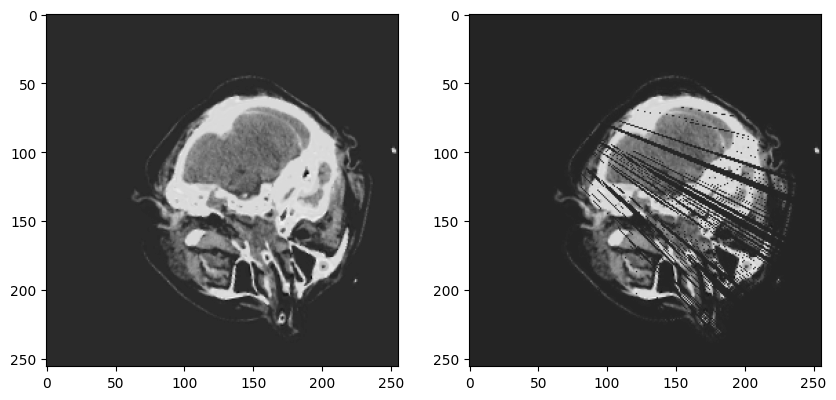

In [29]:
def create_probe_artifact(volume):
    def for_one_slice(image):
        img_copy = image.copy()
        THRESHOLD = 0.1
        thresh = img_copy*255>THRESHOLD
        # Find contours of bright regions
        contours, _ = cv2.findContours(thresh.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Draw star-like pattern on the image
        for contour in contours:
            # Calculate the centroid of each contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"]*2 / M["m00"]*0.02) #int(M["m10"] / M["m00"])
                cY = int(M["m01"]*1.6 / M["m00"]*0.2)
            else:
                cX, cY = 50, 50
            # Draw lines from centroid to contour points
            for point in contour:
                x, y = point[0]
                cv2.line(img_copy, (cX, cY), (x, y), (255, 255, 255), 1)
        distorted = img_copy*image
        return distorted
    
    
    volume_with_artifact= []
    for slice in range(volume.shape[-1]):
        volume_with_artifact.append(for_one_slice(volume[:,:,slice]))
    volume_with_artifact = np.array(volume_with_artifact)
    volume_with_artifact = np.transpose(volume_with_artifact,(1,2,0))
    return volume_with_artifact

dist = create_probe_artifact(X[1])
print(dist[:,:,56][50,50])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(X[1][:,:,24],cmap='gray')
plt.subplot(1,2,2),plt.imshow(dist[:,:,24],cmap='gray')
